In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet50
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
dataset_path = "/kaggle/input/teethdata/Teeth_Dataset"  # Updated dataset path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
train_dataset = ImageFolder(root=f"{dataset_path}/Training", transform=transform_train)
test_dataset = ImageFolder(root=f"{dataset_path}/Testing", transform=transform_test)
val_dataset = ImageFolder(root=f"{dataset_path}/Validation", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


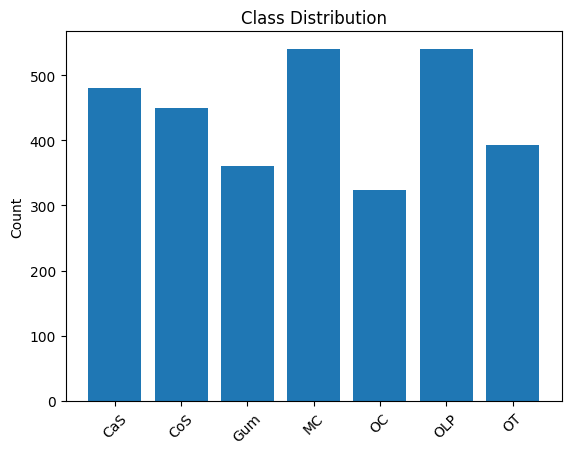

In [17]:
train_class_names = train_dataset.classes
class_counts = [0] * len(class_names)
for _, label in train_dataset:
    class_counts[label] += 1

plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

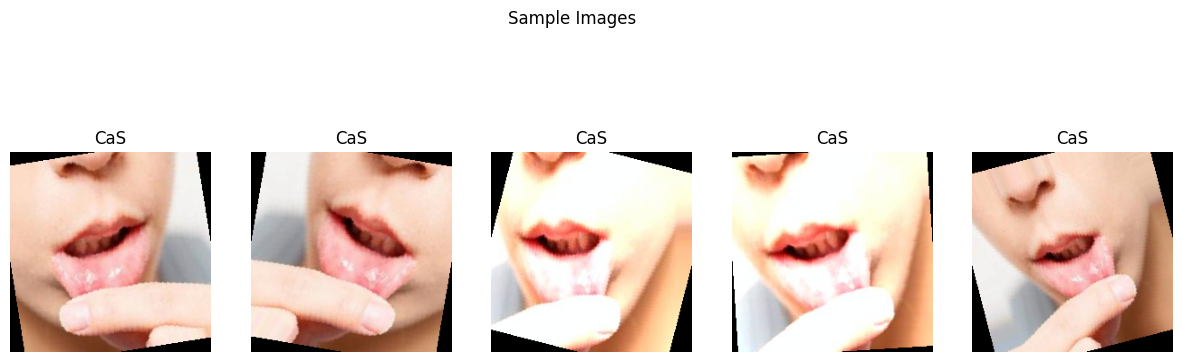

In [6]:
# Display images before augmentation
def show_images(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        ax.set_title(class_names[label])
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_dataset, "Sample Images")


In [9]:
import torch
import torchvision.models as models
from torch import nn, optim

# Load the model with the correct weights parameter
model = models.resnet50(weights=None)  # Use `weights=None` instead of `pretrained=False`

# Manually load the weights with `weights_only=True` for security
weights_path = "/kaggle/input/resnetwieghts/pytorch/default/1/resnet50-0676ba61.pth"
model.load_state_dict(torch.load(weights_path, weights_only=True))  # Set `weights_only=True`

# Modify the final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define Training Components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=80):
    best_model_wts = None
    best_acc = 0.0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_val_loss = running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Plot training/validation losses and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [19]:
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")



In [20]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    model.to(device)  
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    
    valid_classes = list(range(len(class_names)))  
    filtered_y_true = []
    filtered_y_pred = []
    for true, pred in zip(y_true, y_pred):
        if true in valid_classes and pred in valid_classes:
            filtered_y_true.append(true)
            filtered_y_pred.append(pred)
    print("Classification Report:")
    print(classification_report(filtered_y_true, filtered_y_pred, target_names=class_names))
    cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=valid_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/80, Train Loss: 1.3698, Val Loss: 1.6699, Val Accuracy: 43.58%
Epoch 2/80, Train Loss: 0.9397, Val Loss: 1.1375, Val Accuracy: 59.73%
Epoch 3/80, Train Loss: 0.7434, Val Loss: 0.9074, Val Accuracy: 66.73%
Epoch 4/80, Train Loss: 0.6333, Val Loss: 0.8360, Val Accuracy: 72.28%
Epoch 5/80, Train Loss: 0.4397, Val Loss: 0.4124, Val Accuracy: 84.14%
Epoch 6/80, Train Loss: 0.4336, Val Loss: 0.4866, Val Accuracy: 82.10%
Epoch 7/80, Train Loss: 0.3383, Val Loss: 1.0310, Val Accuracy: 71.30%
Epoch 8/80, Train Loss: 0.2983, Val Loss: 0.5336, Val Accuracy: 81.91%
Epoch 9/80, Train Loss: 0.2418, Val Loss: 0.4021, Val Accuracy: 86.96%
Epoch 10/80, Train Loss: 0.2043, Val Loss: 0.3557, Val Accuracy: 88.33%
Epoch 11/80, Train Loss: 0.2245, Val Loss: 0.3146, Val Accuracy: 88.81%
Epoch 12/80, Train Loss: 0.1656, Val Loss: 0.1405, Val Accuracy: 95.53%
Epoch 13/80, Train Loss: 0.1690, Val Loss: 0.2511, Val Accuracy: 91.15%
Epoch 14/80, Train Loss: 0.1669, Val Loss: 0.1239, Val Accuracy: 95.62%
E

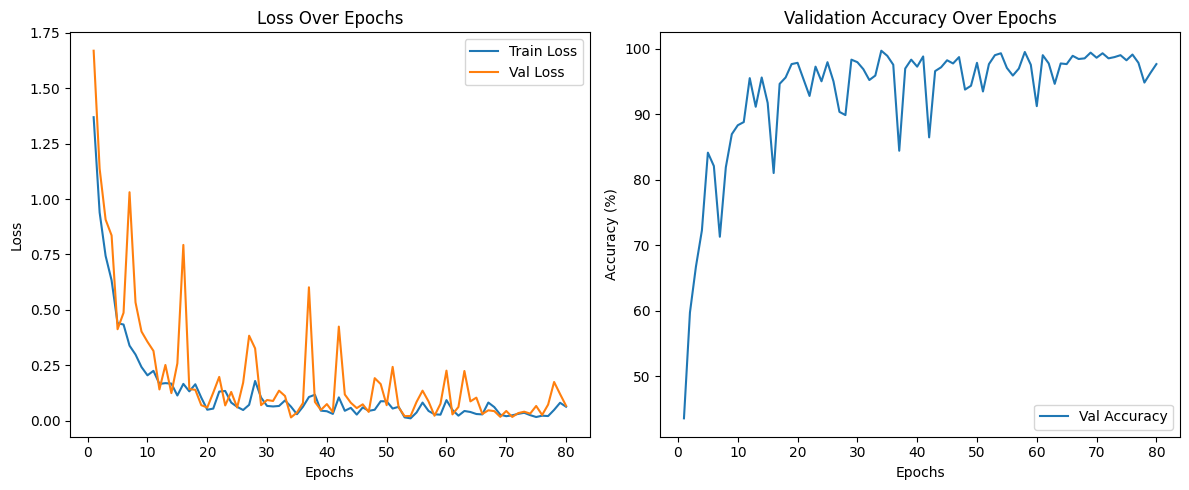

In [14]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer)

In [15]:
save_model(trained_model)

Model saved to best_model.pth


Classification Report:
              precision    recall  f1-score   support

         CaS       0.98      0.99      0.98       160
         CoS       0.98      1.00      0.99       149
         Gum       0.99      0.96      0.97       120
          MC       0.99      0.93      0.96       180
          OC       0.94      0.99      0.96       108
         OLP       0.99      0.93      0.96       180
          OT       0.91      1.00      0.95       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



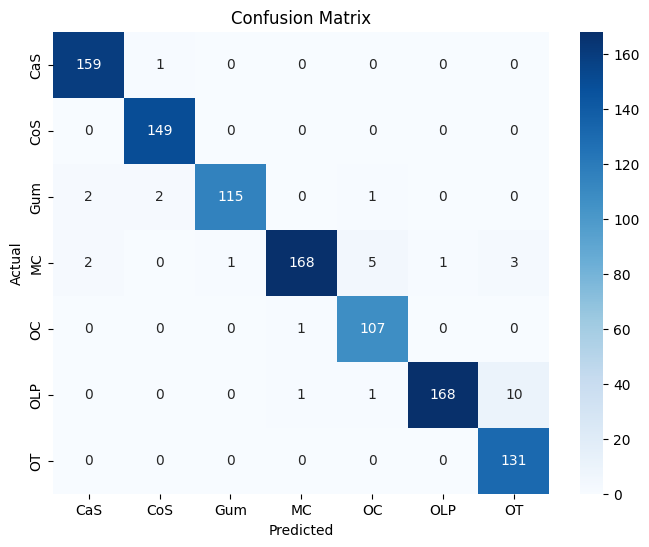

In [21]:
evaluate_model(trained_model, test_loader,train_class_names)

In [22]:
from PIL import Image

# Step 1: Load the saved model
def load_model(path="/kaggle/working/best_model.pth"):
    model = resnet50(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(class_names))
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully.")
    return model

loaded_model = load_model()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


<ipython-input-22-d23c30dab32b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [30]:
# Step 2: Preprocess the manual image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

manual_image_path = "/kaggle/input/teethdata/Teeth_Dataset/Testing/MC/mc_1201_0_8540.jpg"  # Replace with the actual path to your image
preprocessed_image = preprocess_image(manual_image_path, transform_test)



In [31]:
from PIL import Image
import torchvision.transforms as transforms

def predict_image(model, image_path, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)
    
    predicted_label = class_names[predicted_class.item()]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label


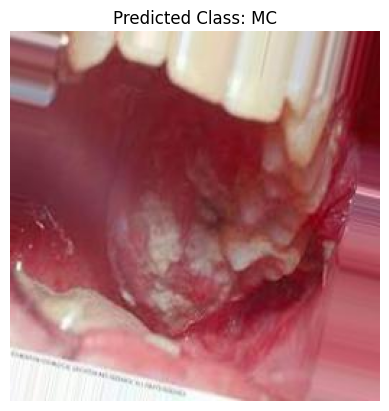

The predicted class is: MC


In [32]:
predicted_class = predict_image(trained_model, manual_image_path, class_names)
print(f"The predicted class is: {predicted_class}")